MOUNTING GOOGLE DRIVE

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Input,InputLayer, Activation, BatchNormalization
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
import numpy as np
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
from keras.callbacks import EarlyStopping

In [6]:
labels = ['NORMAL', 'PNEUMONIA']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img = cv2.imread(img_path)
                if img is None:
                    continue  # Skip if the image cannot be loaded

                resized_arr = cv2.resize(img, (img_size, img_size))

                contrast = int((177 - 0) * (127 - (-127)) / (254 - 0) + (-127))
                Alpha = float(131 * (contrast + 127)) / (127 * (131 - contrast))
                Gamma = 127 * (1 - Alpha)
                cntrst = cv2.addWeighted(resized_arr, Alpha, resized_arr, 0, Gamma)

                data.append([cntrst, class_num])
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
    return np.array(data, dtype=object)

test = get_data("/content/drive/MyDrive/Pneumonia detection using xray images/Dataset/test")
val = get_data("/content/drive/MyDrive/Pneumonia detection using xray images/Dataset/val")

In [ ]:

train = get_data("/content/drive/MyDrive/Pneumonia detection using xray images/Dataset/train")
x_train = []
y_train = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

In [7]:

x_val=[]
y_val=[]
x_test = []
y_test = []


for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

In [ ]:
# Normalize the data
x_train = np.array(x_train,dtype=np.float16) / 255


In [8]:
x_test = np.array(x_test,dtype=np.float16) / 255
x_val = np.array(x_val,dtype=np.float16) / 255

In [ ]:
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)


In [9]:

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [ ]:
# training data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
datagen.fit(x_train)

VGG19



In [12]:
from keras.applications import VGG19
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Define image size
image_size = (224, 224)

# Function to build VGG19 model
def build_vgg19():
    # Load pre-trained VGG19 model with ImageNet weights
    base_model = VGG19(input_shape=(image_size[0], image_size[1], 3), weights='imagenet', include_top=False)

    # Freeze base model layers to prevent training
    for layer in base_model.layers:
        layer.trainable = False

    # Flatten the output of the base model
    x = Flatten()(base_model.output)

    # Add a dense layer with ReLU activation and dropout
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer with sigmoid activation for binary classification
    outputs = Dense(1, activation='sigmoid')(x)

    # Construct the model
    model = Model(inputs=base_model.input, outputs=outputs)
    return model


In [ ]:
# Compile and train VGG19
vgg19_model = build_vgg19()
vgg19_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [13]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)


In [ ]:
# Train the model
vgg19_history = vgg19_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=16,
    callbacks=[lr_scheduler]
)

Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.8541 - loss: 0.9772 - val_accuracy: 0.8889 - val_loss: 0.2618 - learning_rate: 0.0010
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.9570 - loss: 0.1121 - val_accuracy: 0.8889 - val_loss: 0.2147 - learning_rate: 0.0010
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.9689 - loss: 0.0866 - val_accuracy: 1.0000 - val_loss: 0.0591 - learning_rate: 0.0010
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - accuracy: 0.9657 - loss: 0.0913 - val_accuracy: 0.9167 - val_loss: 0.0958 - learning_rate: 0.0010
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.9649 - loss: 0.0925 - val_accuracy: 0.9444 - val_loss: 0.1038 - learning_rate: 0.0010
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.9695 - loss: 0.0860 - val_accuracy: 1.0000 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - accuracy: 0.9660 - l

In [ ]:
# Save the entire model to a file
model_path = '/content/drive/MyDrive/Pneumonia detection using xray images/saved models/vgg19saved.h5'
vgg19_model.save(model_path)

In [14]:
from sklearn.metrics import classification_report, accuracy_score

# Load the saved VGG19 model
vgg19_saved = tf.keras.models.load_model('/content/drive/MyDrive/Pneumonia detection using xray images/saved models/vgg19saved.h5')

# Assuming you have your test data (x_test and y_test)
# Make predictions for the test set
predictions = vgg19_saved.predict(x_test)

# Convert the predicted probabilities to class labels for binary classification
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Ensure y_test is in binary labels format (0 or 1)
y_test_classes = y_test.flatten()  # Flatten if necessary, assuming y_test is already shaped appropriately

# Print the classification report
print(classification_report(y_test_classes, predicted_classes, target_names=['NORMAL (Class 0)', 'PNEUMONIA (Class 1)']))

# Calculate and print the accuracy
accuracy = accuracy_score(y_test_classes, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print the precision and recall
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test_classes, predicted_classes, zero_division=1)
recall = recall_score(y_test_classes, predicted_classes, zero_division=1)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step
                     precision    recall  f1-score   support

   NORMAL (Class 0)       0.98      0.44      0.61       234
PNEUMONIA (Class 1)       0.75      0.99      0.85       390

           accuracy                           0.79       624
          macro avg       0.87      0.72      0.73       624
       weighted avg       0.84      0.79      0.76       624

Accuracy: 0.7885
Precision: 0.7490
Recall: 0.9949


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


<Figure size 800x600 with 0 Axes>

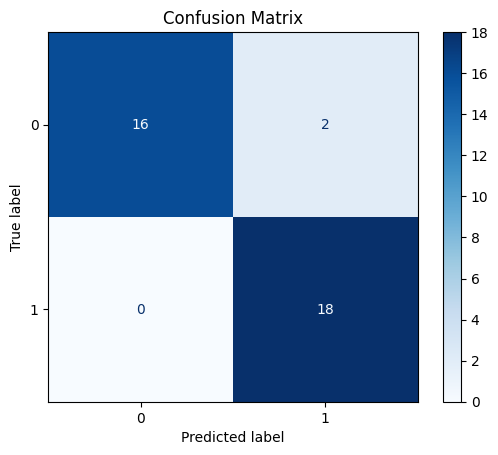

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have your validation data (x_val and y_val)
# Make predictions for the validation set
y_pred = vgg19_saved.predict(x_val)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary classes (0 or 1)

# Ensure y_val is in binary labels format (0 or 1)
y_val_classes = y_val.flatten()  # Flatten if necessary, assuming y_val is already shaped appropriately

# Calculate confusion matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Adjust display_labels based on your classes
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()